# GPU programming using PyOpenCL, part 2: Gather

This is a set of exercises on the usage of PyOpenCL. There are 6 main classes of parallel algorithms:
1. Map or Element-wise kernels: 1 thread calculates 1 result from 1 input position
2. Gather: 1 thread calculates 1 result from several input data, one typical example is the convolution
3. Scatter: 1 thread uses 1 input element and scatters it on one or several output pixels, this requires the usage of atomic operarions
4. Reduction: Apply the same associative operation on all element of an ensemble, for example the sum of all elements in a list.
5. Scan: also called prefix sum, this algorithm applies the same associative operation to all *previous* elements of a list, for example a cummulative sum (cumsum)
6. Sort: using sorting network like the bitonic sort.

This Second tutorial focuses on the **Gather** operation applied to (visible light) image treatement. 
It consists of two part: an example of usage, followed by the direct application in an exercise to be done.

* Demonstration of the context using Sobel filter
* Binning as exercise

First we load some python modules to be able to read and display images. Then we initialize OpenCL, a context, a command queue, ...

In [1]:
%matplotlib widget
from math import ceil
import numpy as np
from PIL import Image
from matplotlib.pyplot import subplots

In [2]:
import pyopencl as cl
from pyopencl import array as cla
from pyopencl.elementwise import ElementwiseKernel

ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

print(ctx.devices[0])

<pyopencl.Device 'NVIDIA RTX A5000' on 'NVIDIA CUDA' at 0x5558856d9aa0>


In [3]:
filename = "14h33m35-SM-N970U1.jpg"
img = np.array(Image.open(filename))
img_d = cla.to_device(queue, img)
gray_d = cla.empty(queue, img.shape[:2], "float32")
luma_ew = ElementwiseKernel(ctx, 
                            arguments="float *L, uchar *rgb", 
                            operation="L[i] = 0.299f * rgb[3*i] + 0.587f * rgb[3*i+1] + 0.114f * rgb[3*i+2]")
luma_ew(gray_d, img_d).wait()

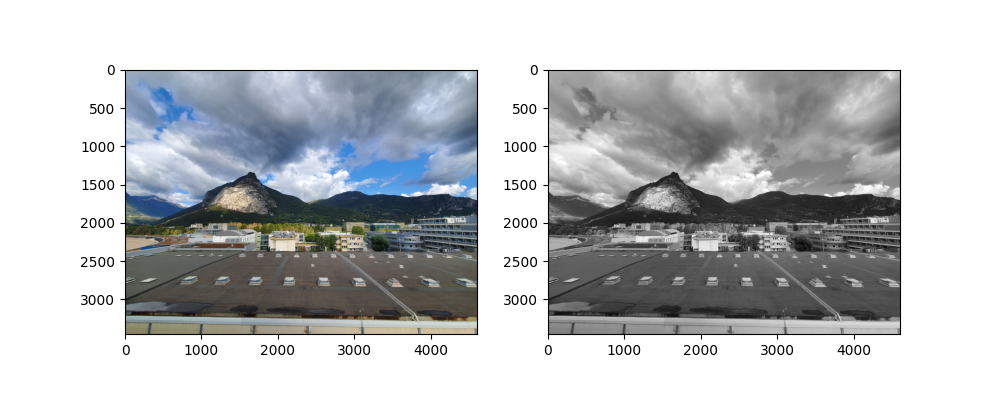

In [4]:
fig, ax = subplots(1, 2, figsize=(10,4))
ax[0].imshow(img)
ax[1].imshow(gray_d.get(), cmap="gray")

In [5]:
R, G, B = img.reshape((-1,3)).T
Y = 0.299*R + 0.587*G + 0.114*B
Y.shape = img.shape[:2]
assert np.allclose(Y, gray_d.get())

In this example we will work on the black&white version of the image.

## Demonstration: [Sobel Filter](https://en.wikipedia.org/wiki/Sobel_operator):

The Sobel extracts the gradiant from an image, it is obtained from the quadratic sum of Gx and Gy:

$$ G_x =  \begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix} \ast I$$

$$ G_y =  \begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix} \ast I$$

$$ G = \sqrt{G_x^2 + G_y^2}$$

Or the Scipy implementation: 

In [6]:
from scipy import ndimage
sobel_h = ndimage.sobel(Y, 0)  # horizontal gradient
sobel_v = ndimage.sobel(Y, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)

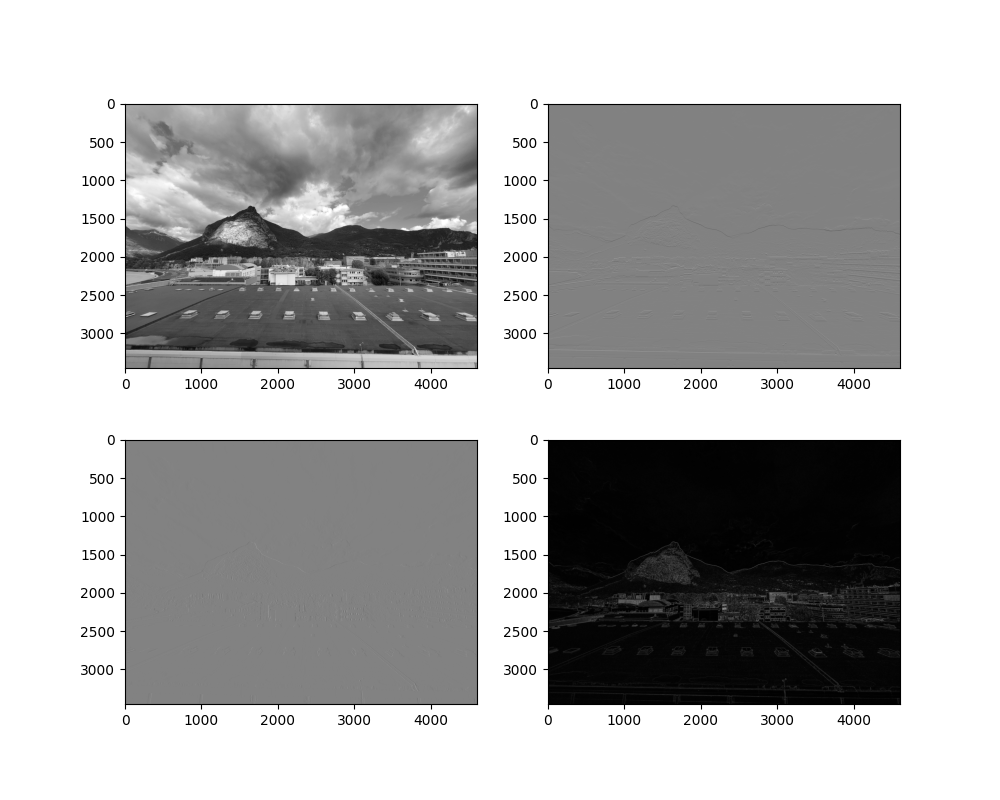

In [7]:
fig, ax = subplots(2, 2, figsize=(10,8))
ax[0,0].imshow(Y, cmap="gray")
ax[0,1].imshow(sobel_h, cmap="gray")
ax[1,0].imshow(sobel_v, cmap="gray")
ax[1,1].imshow(magnitude, cmap="gray")

In [8]:
%load_ext pyopencl.ipython_ext

In [9]:
%%cl_kernel

kernel void sobel(global float *img, 
                  global float *sob, 
                 int height, 
                 int width,
                 int axis)
{
    int x, y;
    y = get_global_id(0);
    x = get_global_id(1);
    if ((x<width) && (y<height))
    {
        float Gx, Gy; 
        int w, i, j, rx, ry, r;

        int avg[3] = {1, 2, 1};
        int dif[3] = {-1, 0, 1};

        Gx = 0.0f;
        Gy = 0.0f;
        for(i=-1; i<2; i++){
            ry = y + i;
            //Boundary conditions: mode reflect
            if (ry<0) ry = abs(ry+1);
            if (ry>=height) ry = 2*height - ry - 1;

            for(j=-1; j<2; j++){
                rx = x + j;
                //Boundary conditions: mode reflect
                if (rx<0) rx = abs(rx+1);
                if (rx>=width) rx = 2*width - rx - 1;

                r = ry*width + rx;
                Gx += avg[j+1] * dif[i+1] * img[r];
                Gy += avg[i+1] * dif[j+1] * img[r];
            }
        }
        w = x + width*y;
        if (axis==0)
            sob[w] = Gx;
        else if (axis==1)
            sob[w] = Gy;
        else 
            sob[w] = sqrt(Gx*Gx + Gy*Gy);
    }
}

In [10]:
wg = (1, 256)#(1,256)#(32, 32)#, (256,1), (1, 256), ...
shape = gray_d.shape[:2] if wg is None else tuple(int(ceil(i/w)*w) for i,w in zip(gray_d.shape, wg))
sob_d = cla.empty_like(gray_d)

In [11]:
evt = sobel(queue, shape, wg, 
              gray_d.data, sob_d.data, 
          np.int32(gray_d.shape[0]), np.int32(gray_d.shape[1]), np.int32(0))

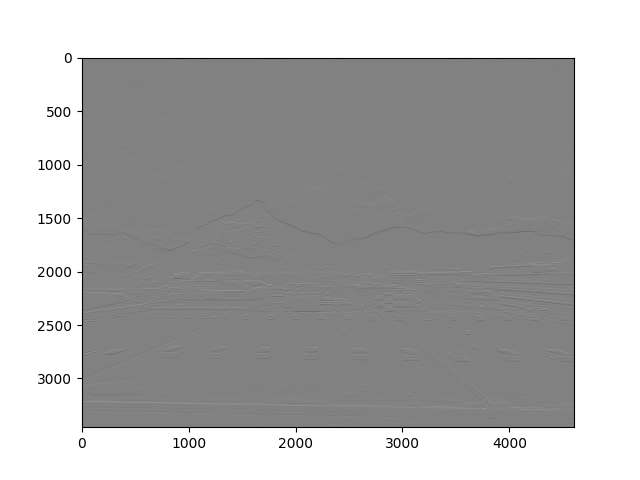

In [12]:
fig,ax = subplots()
ax.imshow(sob_d.get(), cmap="gray")

In [13]:
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms (GPU)")
%timeit ndimage.sobel(Y, 0)  # horizontal gradient
assert np.allclose(sobel_h, sob_d.get(), rtol=1e-3, atol=1e-3)

Profile time: 0.253ms (GPU)
385 ms ± 62.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
evt = sobel(queue, shape, wg, 
              gray_d.data, sob_d.data, 
              np.int32(gray_d.shape[0]), np.int32(gray_d.shape[1]), np.int32(1))
assert np.allclose(sobel_v, sob_d.get(), rtol=1e-3, atol=1e-3)
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms (GPU)")
%timeit ndimage.sobel(Y, 1)  # vertical gradient

Profile time: 0.245ms (GPU)
296 ms ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
evt = sobel(queue, shape, wg, 
              gray_d.data, sob_d.data, 
              np.int32(gray_d.shape[0]), np.int32(gray_d.shape[1]), np.int32(3))
assert np.allclose(magnitude, sob_d.get(), rtol=1e-3, atol=1e-3)
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms (GPU)")
%timeit np.sqrt(sobel_h**2 + sobel_v**2)

Profile time: 0.265ms (GPU)
86.6 ms ± 6.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


One can play with the workgroup size for best performances ...

## Now it is your turn:

Write a kernel called *binner* which performs the [binning 2x2 of an image](https://en.wikipedia.org/wiki/Pixel_binning), i.e. the resulting pixels are 2x2 times larger and contains the sum of the pixel intensities from the 4 adjacent pixels. As a consequence, there are 4x less pixels.

Test this kernel and compare the results and performances with the reference implementation

Here is the reference test function in numpy:

In [16]:
binned = Y.reshape(Y.shape[0]//2, 2, Y.shape[1]//2, 2).sum(axis=(1,-1))

In [17]:
%%cl_kernel

UsageError: %%cl_kernel is a cell magic, but the cell body is empty.


In [ ]:
wg = None
shape_in = gray_d.shape
shape_out = tuple(s//2 for s in shape_in)
bin_d = cla.empty(queue, shape_out, "float32")
shape_out = shape_out if wg is None else tuple(int(ceil(i/w)*w) for i,w in zip(shape_out, wg))